# Answer the questions

### 1. Propose a New Method to Initialize Cluster Centroids for K-means

**Proposed Method: Density-Based Seed Initialization (DBSI)**  
This method uses density estimation to pick initial centroids that align with the data's natural structure.  
**Steps:**  
- Estimate the density of data points using kernel density estimation (K cadence) or a histogram-based approach.  
- Identify the *k* points or regions with the highest density.  
- Apply a small random perturbation to these high-density points to avoid selecting centroids too close together.  
- Use these perturbed points as initial centroids for K-means.

**Comparison of Initialization Methods**  
*Forgy Method:*  
- Description: Randomly select *k* data points from the dataset as initial centroids.  
- Advantages:  
  - Simple and fast to implement.  
  - Works reasonably well for well-separated clusters.  
- Disadvantages:  
  - Sensitive to outliers, as it might pick them as centroids.  
  - Struggles with unevenly sized or non-convex clusters.  
  - Results vary due to randomness, leading to inconsistent outcomes.  

*Random Partition Method:*  
- Description: Randomly assign each data point to one of *k* clusters, then compute the mean of each cluster as the initial centroid.  
- Advantages:  
  - Less sensitive to outliers than Forgy.  
  - Better handles uneven cluster sizes.  
  - Easy to implement.  
- Disadvantages:  
  - Still random, so results can vary.  
  - Poor initial assignments can lead to suboptimal centroids.  
  - Slightly more computationally expensive than Forgy due to initial mean calculations.  

*DBSI (Proposed Method):*  
- Description: Select *k* high-density points using density estimation, perturb them slightly, and use them as centroids.  
- Advantages:  
  - Places centroids in dense regions, speeding up convergence.  
  - Robust to outliers, as low-density points are ignored.  
  - Captures natural cluster structures, even for non-convex clusters.  
- Disadvantages:  
  - Density estimation (e.g., KDE) is computationally expensive, especially for large datasets.  
  - Sensitive to parameters like bandwidth in KDE.  
  - Perturbation step needs careful tuning to avoid overlapping centroids.  

### 2. Describe How Clustering Can Speed Up the KNN Model

**Using Clustering to Speed Up KNN**  
K-Nearest Neighbors (KNN) is slow because it calculates distances between a query point and all dataset points. Clustering reduces this by grouping similar points, limiting the search to relevant clusters.  
**Approach:**  
- Preprocess the training dataset with a clustering algorithm like K-means to form *k* clusters.  
- Store the centroids and the points in each cluster.  
- For a query point, compute its distance to each centroid and select the nearest cluster(s) (e.g., top 1 or 2).  
- Run KNN only on the points in the selected cluster(s), reducing distance calculations.  
- Optionally, include points from nearby clusters or use a distance threshold to avoid missing neighbors near cluster boundaries.  

**Role of KD-Tree**  
A KD-tree is a data structure that organizes points in a *k*-dimensional space for fast nearest-neighbor searches. It splits the space into half-spaces along one dimension at each level, forming a binary tree.  
- Connection to Clustering: KD-trees can replace or complement clustering. Instead of grouping points into clusters, KD-trees partition the space into regions, allowing KNN to skip distant regions and focus on nearby points.  
- Comparison:  
  - Clustering reduces the search space but may miss neighbors near cluster boundaries unless multiple clusters are searched.  
  - KD-trees provide exact neighbors by finely partitioning the space but struggle in very high-dimensional data due to the curse of dimensionality.  
  - A hybrid approach could use clustering for coarse grouping and KD-trees within clusters for precise searches, balancing speed and accuracy.  

**Benefits of Clustering for KNN:**  
- Fewer distance calculations, speeding up queries, especially for large datasets.  
- Effective in high-dimensional spaces where KD-trees may perform poorly.  
- Simple to implement with any clustering algorithm.  

**Limitations:**  
- Clustering adds preprocessing time to compute clusters and centroids.  
- May miss neighbors if the query point is near a cluster boundary and only one cluster is searched.  
- Performance depends on clustering quality, as poor centroids or cluster sizes can reduce effectiveness.

# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import Lasso
from scipy.spatial.distance import cdist
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import silhouette_score, r2_score, mean_absolute_error, mean_squared_error

# Data preprocessing

In [2]:
raw_train_data = pd.read_json('data/train.json')
data_trains = raw_train_data[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'interest_level', 'features', 'price']]
data_train = data_trains.copy()

lower_bound = data_train['price'].quantile(0.01)
upper_bound = data_train['price'].quantile(0.99)
data_train = data_train[(data_train['price'] >= lower_bound) & (data_train['price'] <= upper_bound)]

data_train

bathrooms  bedrooms  longitude  latitude interest_level  \
4             1.0         1   -73.9539   40.7108         medium   
6             1.0         2   -73.9722   40.7513            low   
9             1.0         2   -73.9625   40.7575         medium   
10            1.5         3   -73.9425   40.7145         medium   
15            1.0         0   -73.9743   40.7439            low   
...           ...       ...        ...       ...            ...   
124000        1.0         3   -73.9396   40.8433            low   
124002        1.0         2   -73.9578   40.8198         medium   
124004        1.0         1   -73.9554   40.5765         medium   
124008        1.0         2   -74.0017   40.7448         medium   
124009        1.0         3   -73.9712   40.7594           high   

                                                 features  price  
4       [Dining Room, Pre-War, Laundry in Building, Di...   2400  
6       [Doorman, Elevator, Laundry in Building, Dishw...   3800  
9       [Doorman, Elevator, Laundry in Building, Laund...   3495  
10                                                     []   3000  
15      [Doorman, Elevator, Fitness Center, Laundry in...   2795  
...                                                   ...    ...  
124000            [Elevator, Dishwasher, Hardwood Floors]   2800  
124002  [Common Outdoor Space, Cats Allowed, Dogs Allo...   2395  
124004  [Dining Room, Elevator, Pre-War, Laundry in Bu...   1850  
124008  [Pre-War, Laundry in Unit, Dishwasher, No Fee,...   4195  
124009  [Dining Room, Elevator, Laundry in Building, D...   4280  

[48379 rows x 7 columns]

In [3]:
one_hot_encoded = pd.get_dummies(data_train['interest_level'], prefix='interest_level')
data_train = pd.concat([data_train, one_hot_encoded], axis=1)
data_train = data_train.drop('interest_level', axis=1)
data_train

bathrooms  bedrooms  longitude  latitude  \
4             1.0         1   -73.9539   40.7108   
6             1.0         2   -73.9722   40.7513   
9             1.0         2   -73.9625   40.7575   
10            1.5         3   -73.9425   40.7145   
15            1.0         0   -73.9743   40.7439   
...           ...       ...        ...       ...   
124000        1.0         3   -73.9396   40.8433   
124002        1.0         2   -73.9578   40.8198   
124004        1.0         1   -73.9554   40.5765   
124008        1.0         2   -74.0017   40.7448   
124009        1.0         3   -73.9712   40.7594   

                                                 features  price  \
4       [Dining Room, Pre-War, Laundry in Building, Di...   2400   
6       [Doorman, Elevator, Laundry in Building, Dishw...   3800   
9       [Doorman, Elevator, Laundry in Building, Laund...   3495   
10                                                     []   3000   
15      [Doorman, Elevator, Fitness Center, Laundry in...   2795   
...                                                   ...    ...   
124000            [Elevator, Dishwasher, Hardwood Floors]   2800   
124002  [Common Outdoor Space, Cats Allowed, Dogs Allo...   2395   
124004  [Dining Room, Elevator, Pre-War, Laundry in Bu...   1850   
124008  [Pre-War, Laundry in Unit, Dishwasher, No Fee,...   4195   
124009  [Dining Room, Elevator, Laundry in Building, D...   4280   

        interest_level_high  interest_level_low  interest_level_medium  
4                     False               False                   True  
6                     False                True                  False  
9                     False               False                   True  
10                    False               False                   True  
15                    False                True                  False  
...                     ...                 ...                    ...  
124000                False                True                  False  
124002                False               False                   True  
124004                False               False                   True  
124008                False               False                   True  
124009                 True               False                  False  

[48379 rows x 9 columns]

In [4]:
def clean_features(features):
    cleaned_features = []
    for f in features:
        cleaned_f = str(f).replace("'", "").replace('"', '').replace('[', '').replace(']', '').strip()
        cleaned_features.append(cleaned_f)
    return cleaned_features

In [5]:
data_train['features'] = data_train['features'].apply(clean_features)

all_features = []
for index, row in data_train.iterrows():
    features = row['features']
    all_features.extend(features)

unique_values = set(all_features)

counter = Counter(all_features)
top_20_features = counter.most_common(20)

for feature_name, _ in top_20_features:
    data_train[feature_name] = data_train['features'].apply(lambda x: int(feature_name in x))

feature_list = ['bathrooms', 'bedrooms', 'longitude', 'latitude', 'interest_level_low', 'interest_level_medium', 'interest_level_high'] + [x[0] for x in top_20_features]

data_train.drop(columns=['features'], inplace=True)
data_train.reset_index(drop=True, inplace=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48379 entries, 0 to 48378
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathrooms              48379 non-null  float64
 1   bedrooms               48379 non-null  int64  
 2   longitude              48379 non-null  float64
 3   latitude               48379 non-null  float64
 4   price                  48379 non-null  int64  
 5   interest_level_high    48379 non-null  bool   
 6   interest_level_low     48379 non-null  bool   
 7   interest_level_medium  48379 non-null  bool   
 8   Elevator               48379 non-null  int64  
 9   Hardwood Floors        48379 non-null  int64  
 10  Cats Allowed           48379 non-null  int64  
 11  Dogs Allowed           48379 non-null  int64  
 12  Doorman                48379 non-null  int64  
 13  Dishwasher             48379 non-null  int64  
 14  No Fee                 48379 non-null  int64  
 15  La

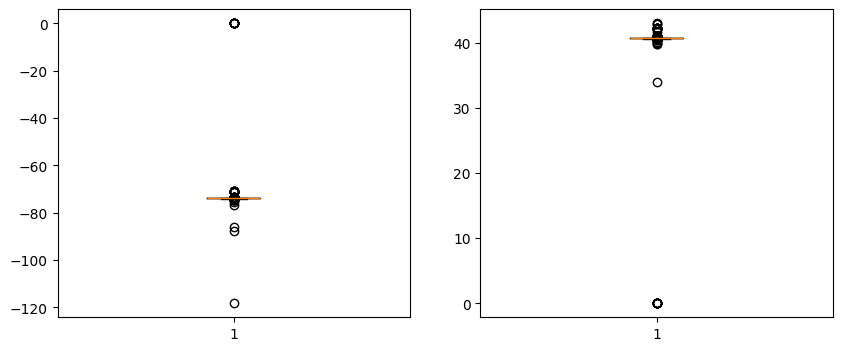

In [6]:
X_train = data_train[['longitude', 'latitude']]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(data_train[['longitude']])
plt.subplot(1, 2, 2)
plt.boxplot(data_train[['latitude']])
plt.show()

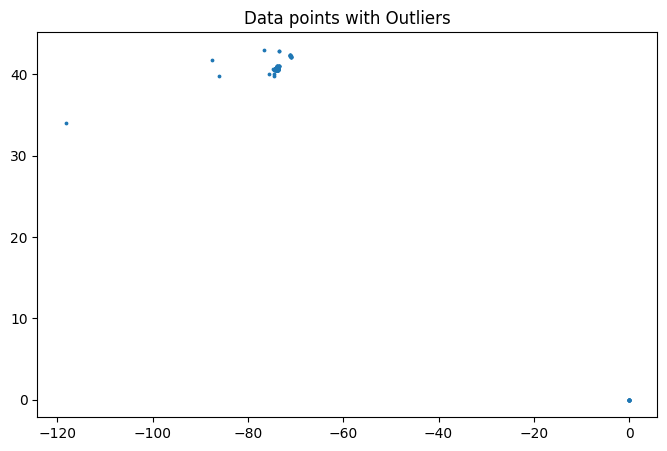

In [7]:

plt.figure(figsize=(8, 5))
plt.scatter(X_train['longitude'], X_train['latitude'], s=3)
plt.title('Data points with Outliers')
plt.show()

17 outliers detected by Z-score


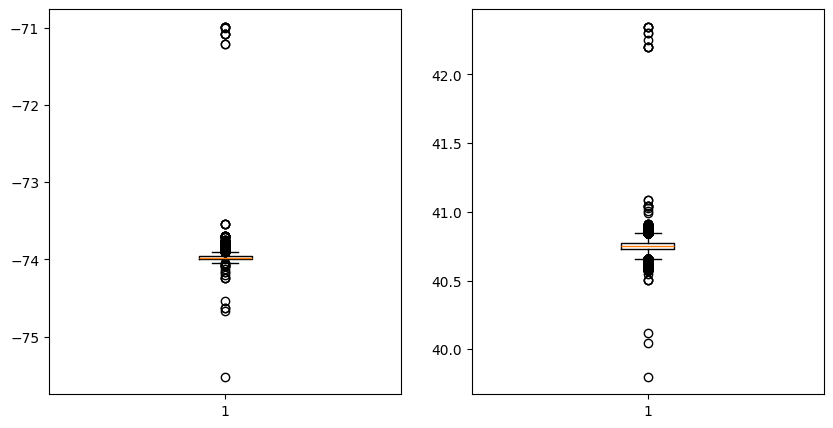

In [8]:
coords = X_train[['longitude', 'latitude']].values
mean = np.mean(coords, axis=0)
std = np.std(coords, axis=0)
z_scores = (coords - mean) / std
outliers_z = np.any(np.abs(z_scores) > 3, axis=1)
outlier_points = X_train[outliers_z]
print(f"{len(outlier_points)} outliers detected by Z-score")

X_train_inliers_z = X_train[~outliers_z]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(X_train_inliers_z[['longitude']])
plt.subplot(1, 2, 2)
plt.boxplot(X_train_inliers_z[['latitude']])
plt.show()

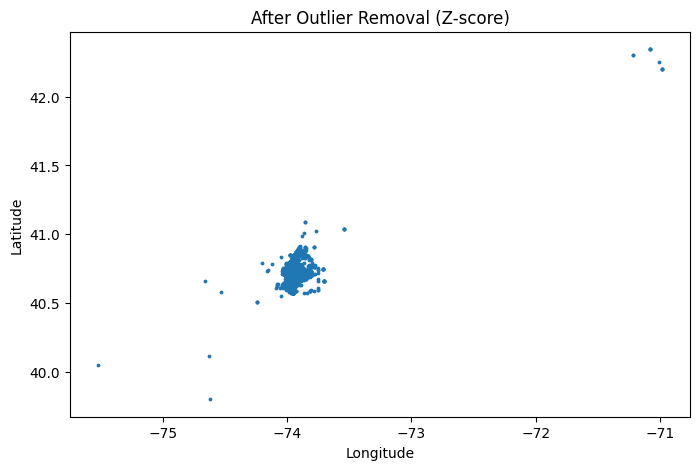

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train_inliers_z['longitude'], X_train_inliers_z['latitude'], s=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('After Outlier Removal (Z-score)')
plt.show()

2496 outliers detected by IQR


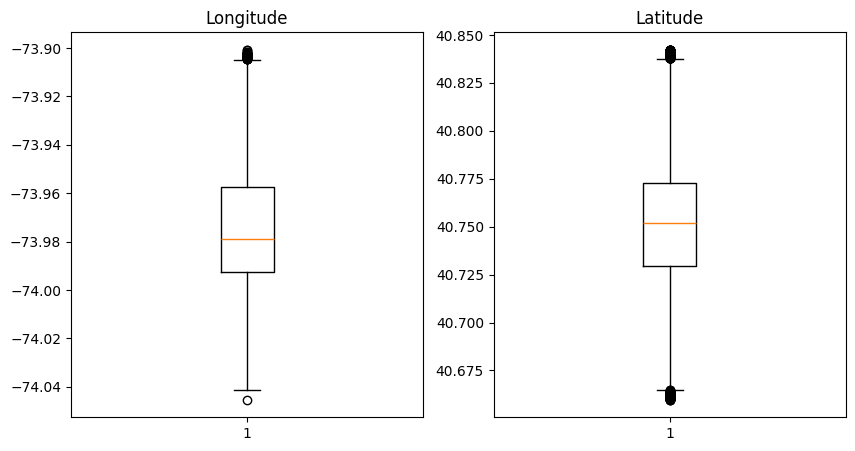

In [10]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

outliers_mask = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_points_iqr = X_train[outliers_mask]
print(f"{len(outlier_points_iqr)} outliers detected by IQR")

X_train_inliers_iqr = X_train[~outliers_mask]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(X_train_inliers_iqr[['longitude']])
plt.title('Longitude')
plt.subplot(1, 2, 2)
plt.boxplot(X_train_inliers_iqr[['latitude']])
plt.title('Latitude')
plt.show()

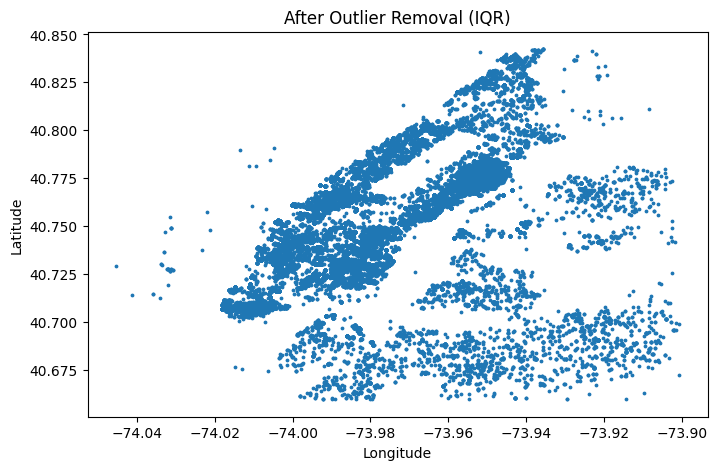

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train_inliers_iqr['longitude'], X_train_inliers_iqr['latitude'], s=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('After Outlier Removal (IQR)')
plt.show()

In [12]:
train_size = int(0.8 * len(X_train_inliers_iqr))
train_df = X_train_inliers_iqr[:train_size]
test_df = X_train_inliers_iqr[train_size:]

X_train = train_df[['longitude', 'latitude']]
X_test = test_df[['longitude', 'latitude']]
y_train = data_train['price'].loc[train_df.index]
y_test = data_train['price'].loc[test_df.index]

# K-means

In [13]:
class CustomKMeans:
    def __init__(self, n_clusters, max_iters=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        if self.random_state:
            np.random.seed(self.random_state)

        min_vals, max_vals = X.min(axis=0), X.max(axis=0)
        self.centroids = np.random.uniform(min_vals, max_vals, (self.n_clusters, X.shape[1]))

        for _ in range(self.max_iters):
            old_centroids = self.centroids.copy()
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels_ = np.argmin(distances, axis=0)

            for k in range(self.n_clusters):
                if np.sum(self.labels_ == k) > 0:
                    self.centroids[k] = X[self.labels_ == k].mean(axis=0)
                else:
                    self.centroids[k] = np.random.uniform(min_vals, max_vals, X.shape[1])

            if np.all(old_centroids == self.centroids):
                break

        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        distances = np.sqrt(((X - self.centroids[:, np.newaxis]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=0)

In [14]:
def plot(X, labels, alg, set=None):
    plt.scatter(X.values[:, 0], X.values[:, 1], c=labels, cmap='tab20', s=3)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"{alg} Clustering ({set if set else ''})")
    plt.colorbar(label="Cluster")
    plt.grid(True)

def lasso_coef(X, y, labels):
    X_aug = X.copy()
    X_aug['cluster'] = labels
    model = make_pipeline(MinMaxScaler(), Lasso(alpha=0.01))
    model.fit(X_aug, y)
    print("Top Feature Importances (Lasso Coefficients):")
    for name, coef in zip(X_aug.columns, model.named_steps['lasso'].coef_):
      print(f"{name:20s}: {coef:.5f}")

def compute_distortion(X, labels, centroids):
    if isinstance(X, pd.DataFrame):
        X = X.values
    distortion = 0
    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            distortion += np.sum((cluster_points - centroids[k])**2)
    return distortion

Custom K-means Silhouette Score: 0.45209750564631285
Custom K-means Distortion: 1.4859638992625097


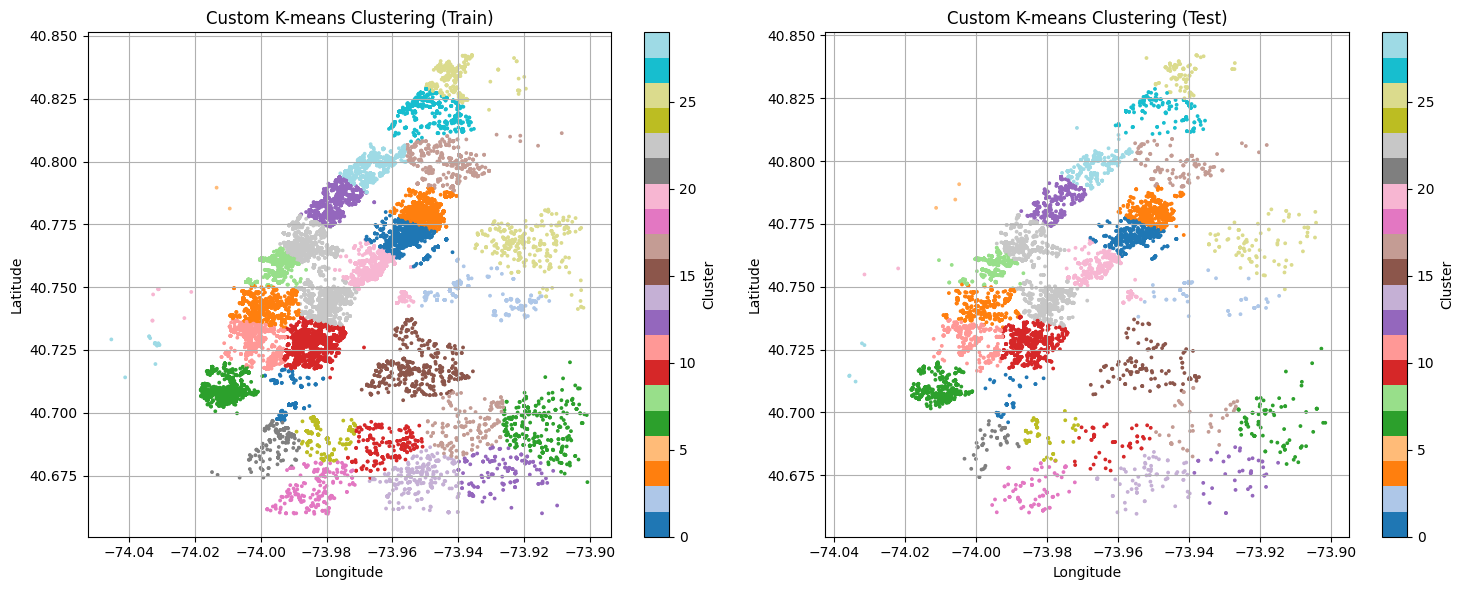

In [15]:
kmeans = CustomKMeans(n_clusters=30, random_state=42)
kmeans.fit(X_train)

train_labels_custom = kmeans.predict(X_train)
test_labels_custom = kmeans.predict(X_test)

print("Custom K-means Silhouette Score:", silhouette_score(X_train, train_labels_custom))
print("Custom K-means Distortion:", compute_distortion(X_train, train_labels_custom, kmeans.centroids))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot(X_train, train_labels_custom, 'Custom K-means', 'Train')
plt.subplot(1, 2, 2)
plot(X_test, test_labels_custom, 'Custom K-means', 'Test')
plt.tight_layout()
plt.show()

In [16]:
lasso_coef(X_train, y_train, train_labels_custom)

Top Feature Importances (Lasso Coefficients):
longitude           : -2661.35755
latitude            : 536.54320
cluster             : -220.29147


Sklearn K-means Silhouette Score: 0.4051397097059116
Sklearn K-means Distortion: 1.238881094933792


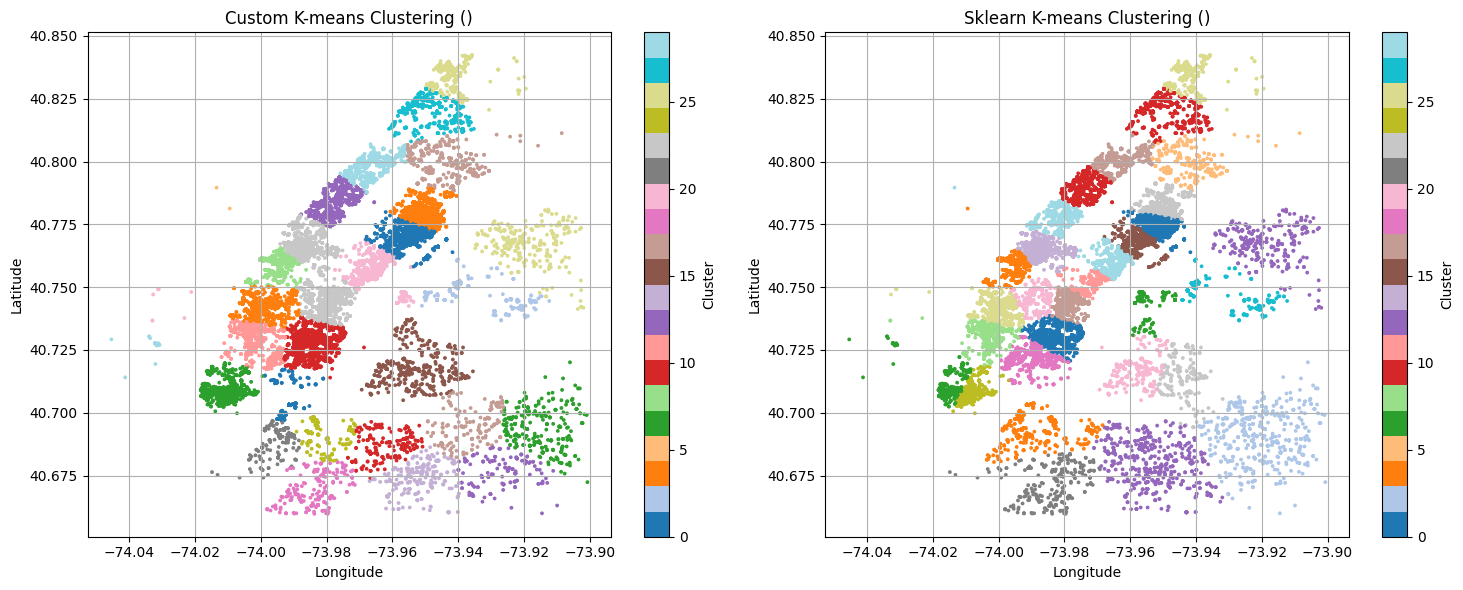

In [17]:
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(X_train)

train_labels_sklearn = kmeans.predict(X_train)
test_labels_sklearn = kmeans.predict(X_test)

print("Sklearn K-means Silhouette Score:", silhouette_score(X_train, train_labels_sklearn))
print("Sklearn K-means Distortion:", kmeans.inertia_)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot(X_train, train_labels_custom, 'Custom K-means')
plt.subplot(1, 2, 2)
plot(X_train, train_labels_sklearn, 'Sklearn K-means')
plt.tight_layout()
plt.show()

# DBSCAN

In [18]:
class CustomDBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_samples = X.shape[0]
        self.labels_ = np.full(n_samples, -1, dtype=int)
        cluster_label = 0

        for point_idx in range(n_samples):
            if self.labels_[point_idx] != -1:
                continue
            neighbors = self._get_neighbors(X, point_idx)
            if len(neighbors) < self.min_samples:
                continue
            self.labels_[point_idx] = cluster_label
            self._expand_cluster(X, point_idx, neighbors, cluster_label)
            cluster_label += 1

        return self

    def _get_neighbors(self, X, point_idx):
        distances = np.sqrt(((X - X[point_idx])**2).sum(axis=1))
        return np.where(distances <= self.eps)[0]

    def _expand_cluster(self, X, point_idx, neighbors, cluster_label):
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_label
            if self.labels_[neighbor_idx] != cluster_label:
                i += 1
                continue
            new_neighbors = self._get_neighbors(X, neighbor_idx)
            if len(new_neighbors) >= self.min_samples:
                neighbors = np.unique(np.concatenate([neighbors, new_neighbors]))
            i += 1

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [19]:
def compute_distortion(X, labels):
    distortion = 0
    for cluster in set(labels):
        cluster_points = X[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        sq_distances = np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
        distortion += sq_distances
    return distortion

Time taken: 2.5367350578308105
Silhouette Score: -0.7189
Distortion: 11.4787


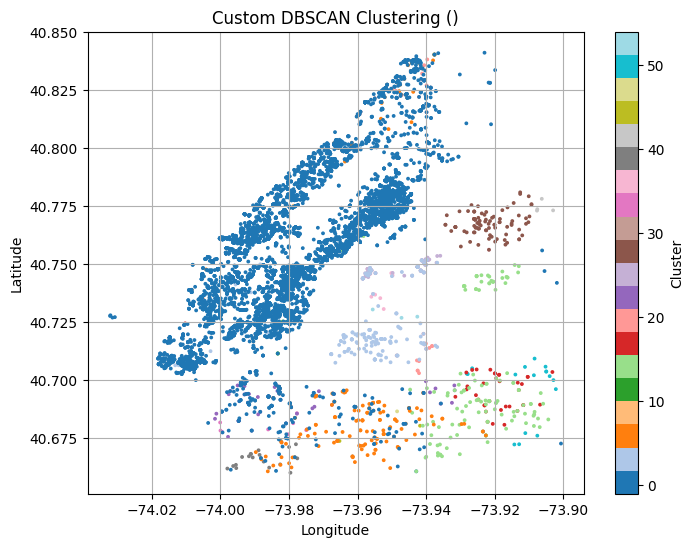

In [20]:
import time

X_sub = X_train.sample(10000)
y_sub = data_train['price'][X_sub.index].values

start = time.time()
dbscan_custom = CustomDBSCAN(eps=0.0075, min_samples=10)
dbscan_custom.fit(X_sub.values)
labels_custom = dbscan_custom.labels_
print("Time taken:", time.time() - start)

print(f"Silhouette Score: {silhouette_score(X_sub, labels_custom):.4f}")
print(f"Distortion: {compute_distortion(X_sub, labels_custom):.4f}")

plt.figure(figsize=(8, 6))
plot(X_sub, labels_custom, 'Custom DBSCAN')
plt.show()

In [21]:
lasso_coef(X_sub, y_sub, labels_custom)

Top Feature Importances (Lasso Coefficients):
longitude           : -2142.70845
latitude            : 188.48303
cluster             : -579.82303


Silhouette Score: -0.1120
Distortion: 42.9586


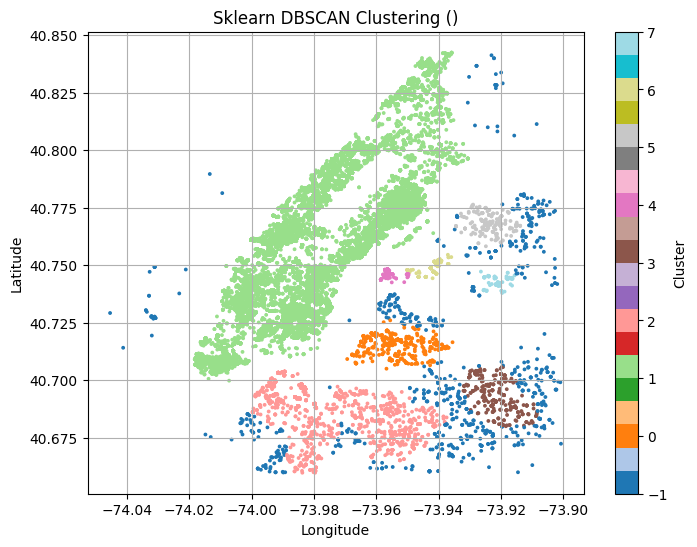

In [22]:
dbscan = DBSCAN(eps=0.005, min_samples=60, n_jobs=-1)
labels_sklearn = dbscan.fit_predict(X_train.values)

print(f"Silhouette Score: {silhouette_score(X_train, labels_sklearn):.4f}")
print(f"Distortion: {compute_distortion(X_train, labels_sklearn):.4f}")

plt.figure(figsize=(8, 6))
plot(X_train, labels_sklearn, 'Sklearn DBSCAN')
plt.show()

In [23]:
eps_list = [0.0035, 0.0055]
min_samples_list = [60, 70]

best_r2 = -float('inf')
best_params = None
best_labels_train = None
best_labels_test = None

start = time.time()
for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_train = dbscan.fit_predict(X_train)
        
        if len(np.unique(labels_train[labels_train != -1])) >= 2:
            silhouette = silhouette_score(X_train, labels_train)
            distortion = compute_distortion(X_train.values, labels_train)  # Передаём NumPy
            
            X_train_aug = X_train.copy()
            X_train_aug['cluster'] = labels_train
            model = make_pipeline(MinMaxScaler(), Lasso(alpha=0.01))
            model.fit(X_train_aug, y_train)
            r2 = model.score(X_train_aug, y_train)
            
            best_r2 = r2
            best_params = (eps, min_samples)
            best_labels_train = labels_train
            best_labels_test = dbscan.fit_predict(X_test)

In [24]:
print(f"\nBest Sklearn DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best Sklearn DBSCAN Silhouette Score: {silhouette_score(X_train, best_labels_train):.5f}")
print(f"Best Sklearn DBSCAN Distortion: {compute_distortion(X_train.values, best_labels_train)}")
print(f"Best Lasso R^2: {best_r2:.5f}")


Best Sklearn DBSCAN parameters: eps=0.0055, min_samples=70
Best Sklearn DBSCAN Silhouette Score: -0.10683
Best Sklearn DBSCAN Distortion: 42.870628992975945
Best Lasso R^2: 0.05617


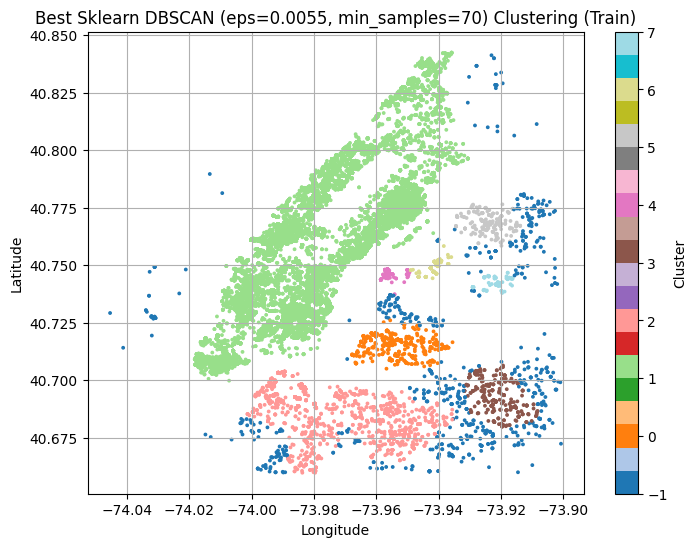

In [25]:
plt.figure(figsize=(8, 6))
plot(X_train, best_labels_train, f'Best Sklearn DBSCAN (eps={best_params[0]}, min_samples={best_params[1]})', 'Train')
plt.show()

# AgglomerativeClustering

AgglomerativeClustering Silhouette Score: 0.406811799969482
AgglomerativeClustering Distortion: 0.724157876654587


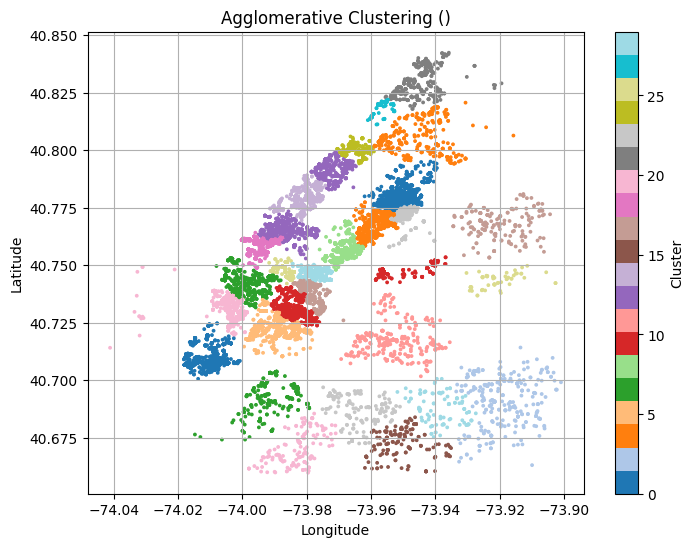

In [26]:
X_sub = X_train.sample(20000)
y_sub = data_train['price'].loc[X_sub.index].values

agglom = AgglomerativeClustering(n_clusters=30)
labels_agg = agglom.fit_predict(X_sub)

print(f"AgglomerativeClustering Silhouette Score:", silhouette_score(X_sub, labels_agg))
print(f"AgglomerativeClustering Distortion:", compute_distortion(X_sub, labels_agg))

plt.figure(figsize=(8, 6))
plot(X_sub, labels_agg, 'Agglomerative')
plt.show()

In [27]:
lasso_coef(X_sub, y_sub, labels_agg)

Top Feature Importances (Lasso Coefficients):
longitude           : -2623.16332
latitude            : 559.59793
cluster             : -279.58955


# Gaussian Mixture

GaussianMixture Silhouette Score: 0.4110596090932883
GaussianMixture Distortion: 1.385110576063652


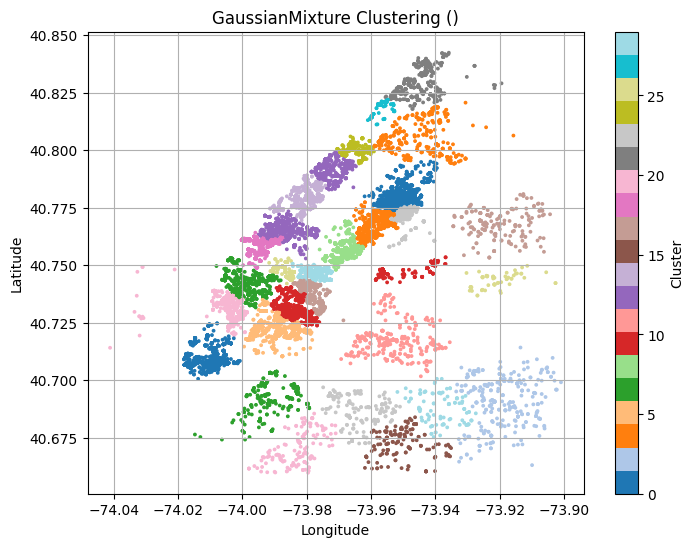

In [28]:
gmm = GaussianMixture(n_components=30)
labels_gmm = gmm.fit_predict(X_train)

print(f"GaussianMixture Silhouette Score:", silhouette_score(X_train, labels_gmm))
print(f"GaussianMixture Distortion:", compute_distortion(X_train, labels_gmm))

plt.figure(figsize=(8, 6))
plot(X_sub, labels_agg, 'GaussianMixture')
plt.show()

In [29]:
lasso_coef(X_train, y_train, labels_gmm)

Top Feature Importances (Lasso Coefficients):
longitude           : -2625.66313
latitude            : 438.49266
cluster             : 123.09848


# Different sets of features

In [30]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def calculate_distortion(X, labels, centers):
    return sum(np.min(cdist(X, centers, 'euclidean'), axis=1)) / X.shape[0]

In [31]:
data_train['amenities_count'] = data_train[['Elevator', 'Hardwood Floors', 'Cats Allowed', 'Dogs Allowed', 'Doorman',
                           'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 
                           'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 
                           'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool',
                           'New Construction', 'Terrace']].sum(axis=1)

data_train['interest_level'] = 0
data_train.loc[data_train['interest_level_medium'], 'interest_level'] = 1
data_train.loc[data_train['interest_level_high'], 'interest_level'] = 2

data_train['price_per_bedroom'] = data_train['price'] / (data_train['bedrooms'] + 1)

feature_sets = {
    'geo_only': ['longitude', 'latitude'],
    'price_amenities': ['price', 'price_per_bedroom', 'amenities_count'],
    "base": ['longitude', 'latitude', 'bedrooms', 'bathrooms', 'interest_level'],
    "geo": ['longitude', 'latitude', 'price'],
     
}

results = []

In [32]:
for feature_set_name, features in feature_sets.items():
    X = data_train[features].copy()

    outlier_columns = [col for col in ['bedrooms', 'bathrooms', 'longitude', 'latitude'] if col in features]
    if outlier_columns:
        X = remove_outliers(X, outlier_columns)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    globals()[f'X_scaled_{feature_set_name}'] = X_scaled
    globals()[f'features_{feature_set_name}'] = features

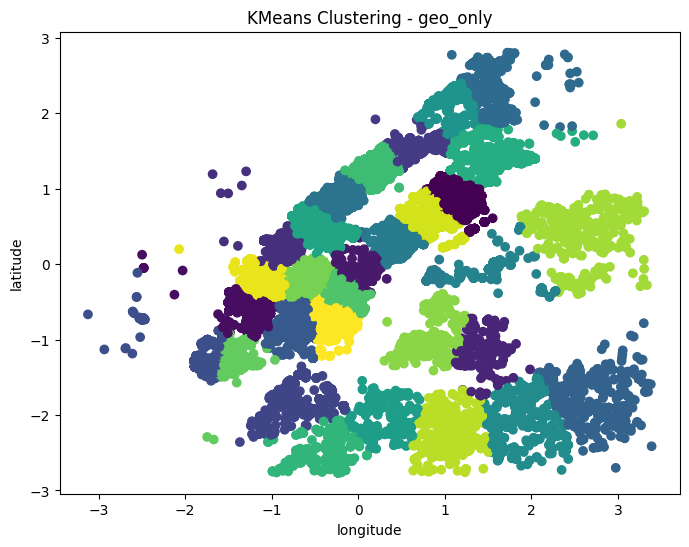

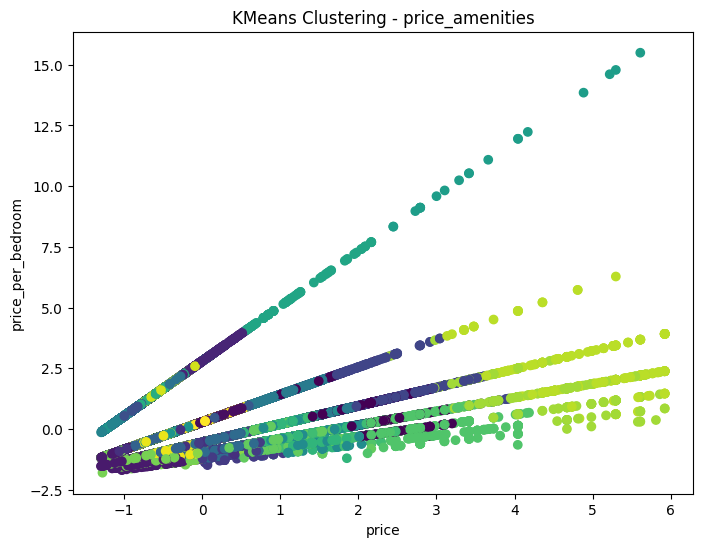

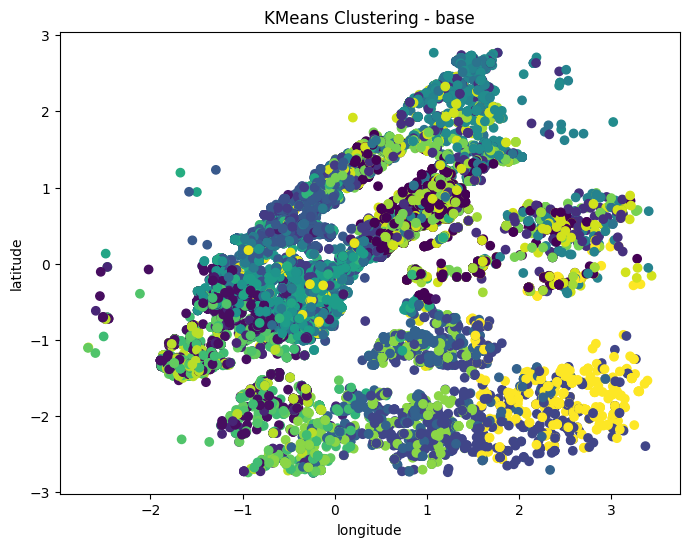

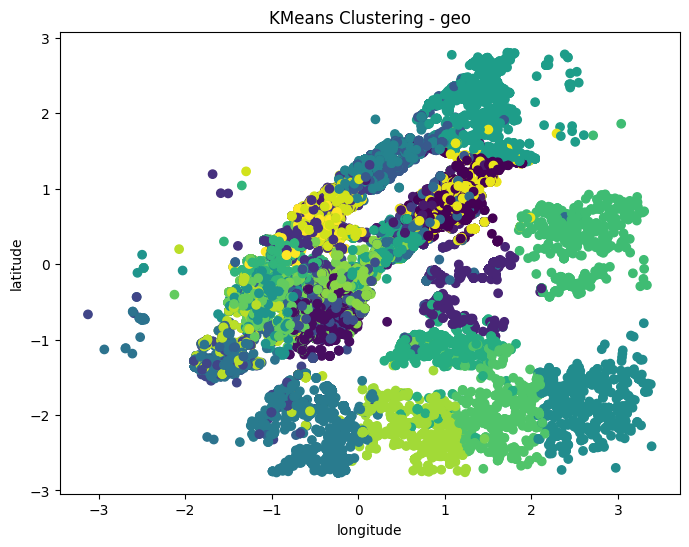

In [33]:
for feature_set_name in feature_sets.keys():
    X_scaled = globals()[f'X_scaled_{feature_set_name}']
    features = globals()[f'features_{feature_set_name}']
    
    model = KMeans(n_clusters=30, random_state=42)
    
    start_time = time.time()
    labels = model.fit_predict(X_scaled)
    runtime = time.time() - start_time
    
    silhouette = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled) else np.nan
    distortion = calculate_distortion(X_scaled, labels, model.cluster_centers_)
    
    results.append({
        'Feature_Set': feature_set_name,
        'Model': 'KMeans',
        'Silhouette_Score': silhouette,
        'Distortion': distortion,
        'Runtime_Seconds': runtime
    })
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
    plt.title(f'KMeans Clustering - {feature_set_name}')
    plt.xlabel(features[0])
    plt.ylabel(features[1] if len(features) > 1 else 'Feature 2')
    plt.show()

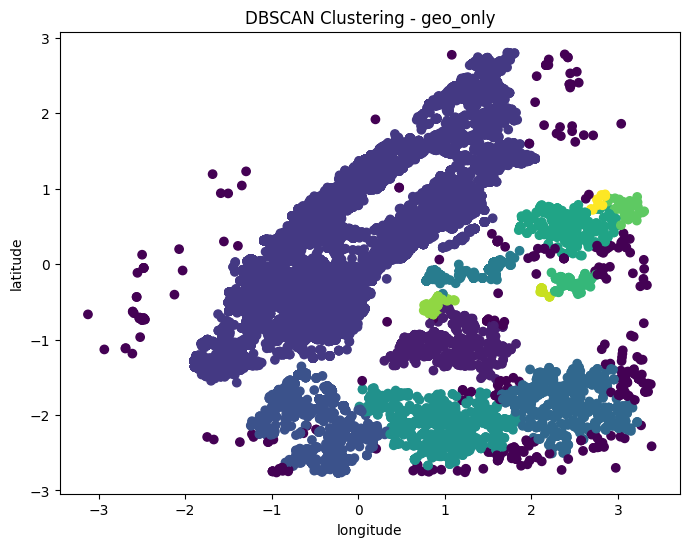

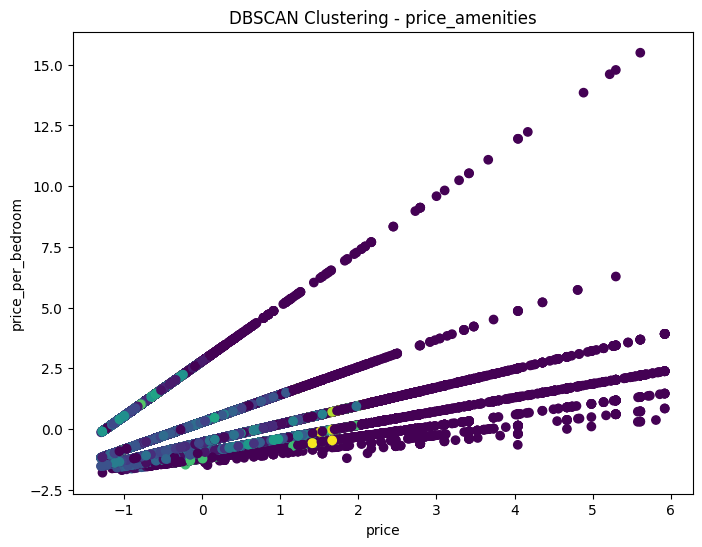

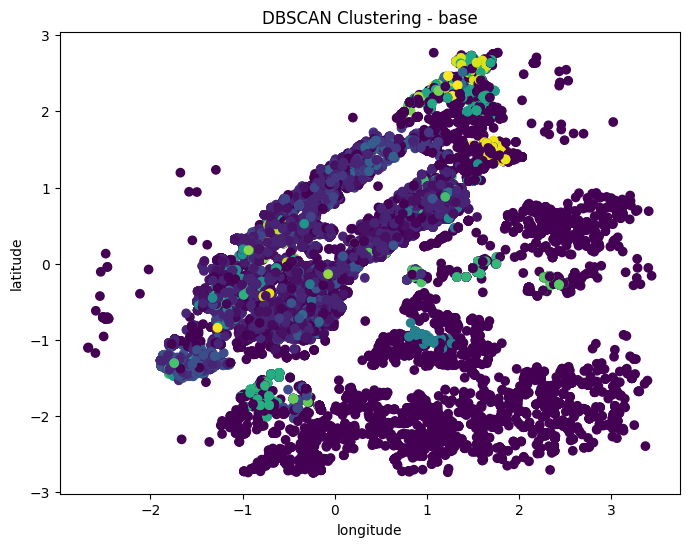

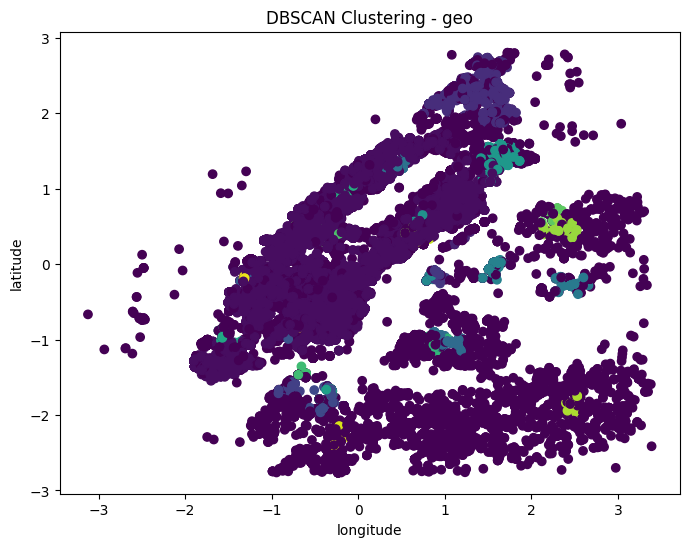

In [34]:
for feature_set_name in feature_sets.keys():
    X_scaled = globals()[f'X_scaled_{feature_set_name}']
    features = globals()[f'features_{feature_set_name}']
    
    model = DBSCAN(eps=0.15, min_samples=30, n_jobs=-1)
    
    start_time = time.time()
    labels = model.fit_predict(X_scaled)
    runtime = time.time() - start_time
    
    silhouette = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled) else np.nan
    distortion = np.nan
    
    results.append({
        'Feature_Set': feature_set_name,
        'Model': 'DBSCAN',
        'Silhouette_Score': silhouette,
        'Distortion': distortion,
        'Runtime_Seconds': runtime
    })
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
    plt.title(f'DBSCAN Clustering - {feature_set_name}')
    plt.xlabel(features[0])
    plt.ylabel(features[1] if len(features) > 1 else 'Feature 2')
    plt.show()

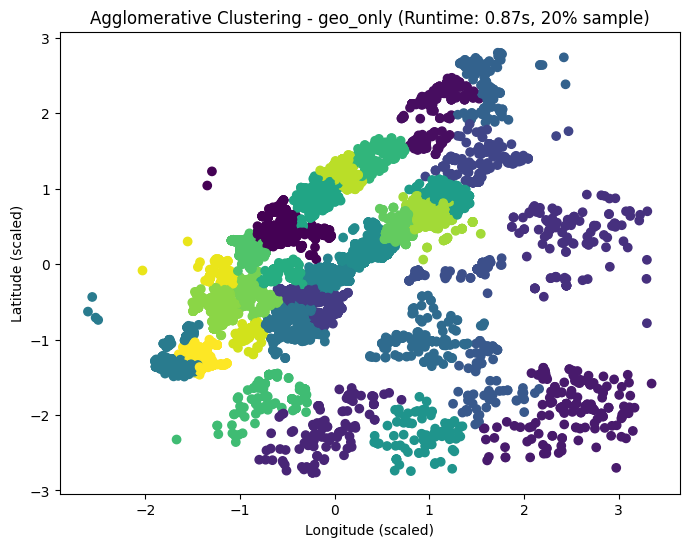

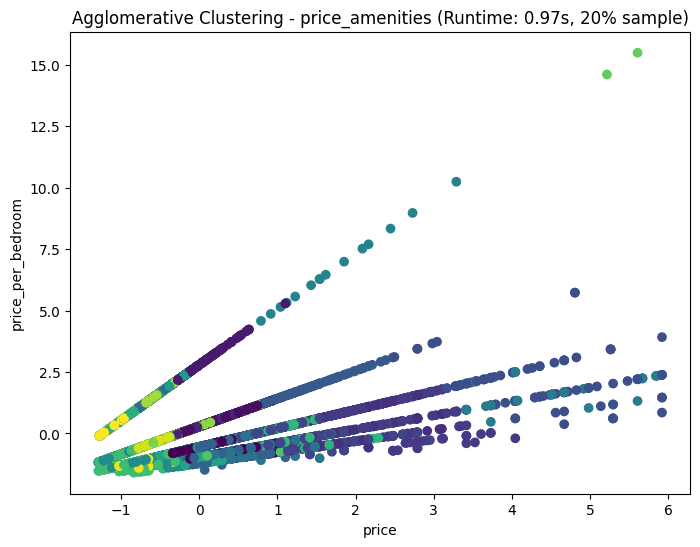

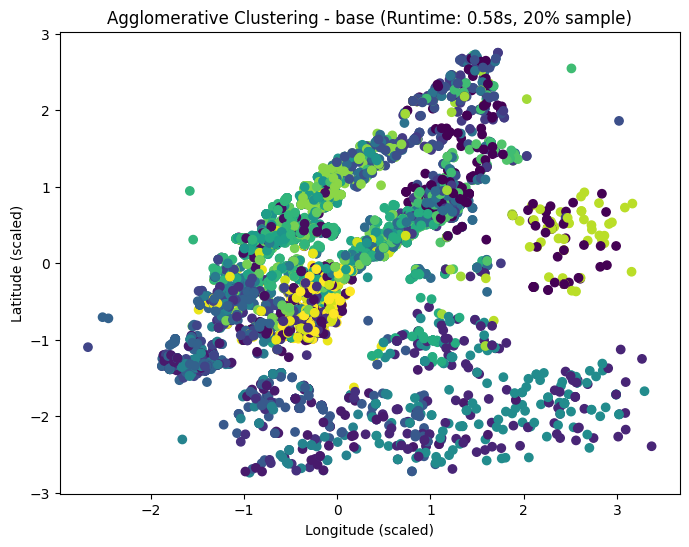

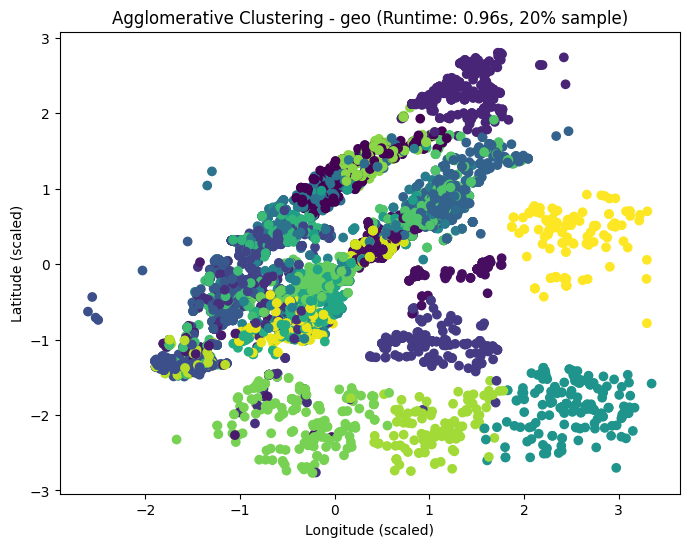

In [35]:
for feature_set_name in feature_sets.keys():
    X_scaled = globals()[f'X_scaled_{feature_set_name}']
    features = globals()[f'features_{feature_set_name}']
    
    np.random.seed(42)
    sample_indices = np.random.choice(X_scaled.shape[0], size=int(X_scaled.shape[0] * 0.2), replace=False)
    X_scaled_sample = X_scaled[sample_indices]
    
    model = AgglomerativeClustering(n_clusters=30)
    
    start_time = time.time()
    labels = model.fit_predict(X_scaled_sample)
    runtime = time.time() - start_time
    
    silhouette = silhouette_score(X_scaled_sample, labels) if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled_sample) else np.nan
    distortion = np.nan
    
    results.append({
        'Feature_Set': feature_set_name,
        'Model': 'Agglomerative',
        'Silhouette_Score': silhouette,
        'Distortion': distortion,
        'Runtime_Seconds': runtime
    })
    
    if 'longitude' in features and 'latitude' in features:
        x_idx, y_idx = features.index('longitude'), features.index('latitude')
        x_label, y_label = 'Longitude (scaled)', 'Latitude (scaled)'
    else:
        x_idx, y_idx = 0, 1 if len(features) > 1 else 0
        x_label, y_label = features[0], features[1] if len(features) > 1 else 'Feature 2'
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled_sample[:, x_idx], X_scaled_sample[:, y_idx], c=labels, cmap='viridis')
    plt.title(f'Agglomerative Clustering - {feature_set_name} (Runtime: {runtime:.2f}s, 20% sample)')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

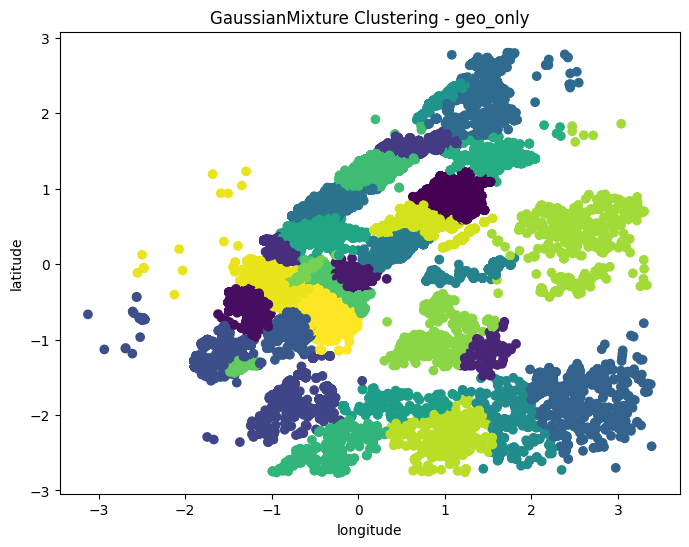

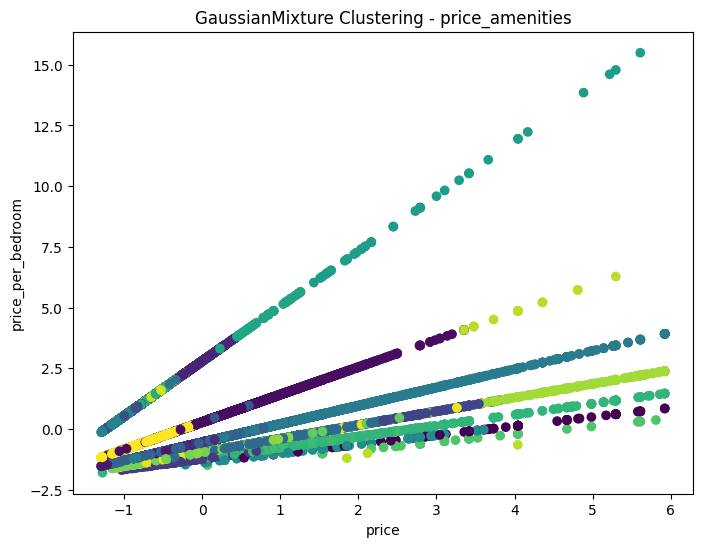

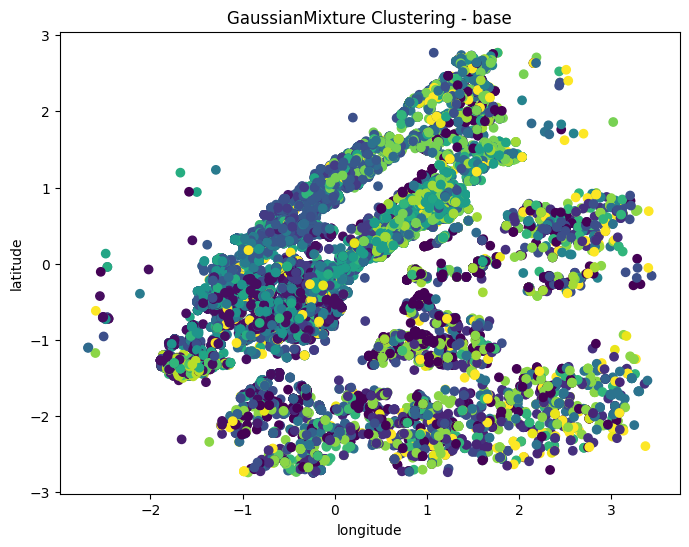

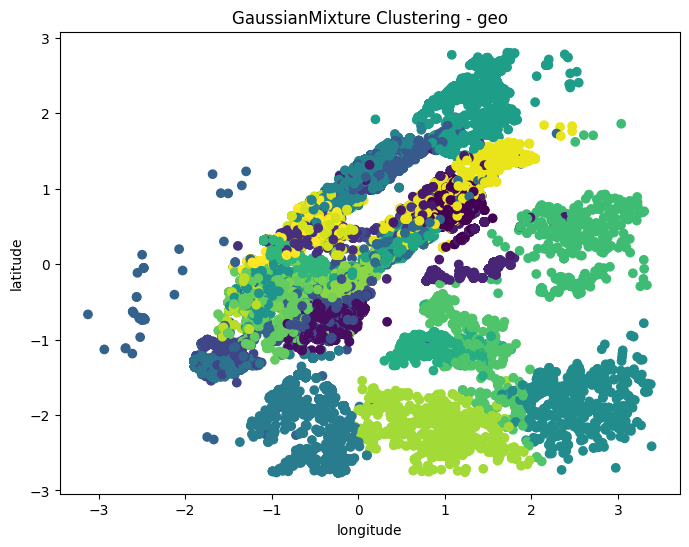

In [36]:
for feature_set_name in feature_sets.keys():
    X_scaled = globals()[f'X_scaled_{feature_set_name}']
    features = globals()[f'features_{feature_set_name}']
    
    model = GaussianMixture(n_components=30, random_state=42)
    
    start_time = time.time()
    labels = model.fit_predict(X_scaled)
    runtime = time.time() - start_time
    
    silhouette = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled) else np.nan
    distortion = calculate_distortion(X_scaled, labels, model.means_)
    
    results.append({
        'Feature_Set': feature_set_name,
        'Model': 'GaussianMixture',
        'Silhouette_Score': silhouette,
        'Distortion': distortion,
        'Runtime_Seconds': runtime
    })
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
    plt.title(f'GaussianMixture Clustering - {feature_set_name}')
    plt.xlabel(features[0])
    plt.ylabel(features[1] if len(features) > 1 else 'Feature 2')
    plt.show()

In [37]:
results_df = pd.DataFrame(results)
results_df

Feature_Set            Model  Silhouette_Score  Distortion  \
0          geo_only           KMeans          0.418190    0.185929   
1   price_amenities           KMeans          0.279566    0.476464   
2              base           KMeans          0.365076    0.619482   
3               geo           KMeans          0.315967    0.436819   
4          geo_only           DBSCAN         -0.050316         NaN   
5   price_amenities           DBSCAN         -0.105173         NaN   
6              base           DBSCAN         -0.060390         NaN   
7               geo           DBSCAN         -0.460955         NaN   
8          geo_only    Agglomerative          0.377619         NaN   
9   price_amenities    Agglomerative          0.237008         NaN   
10             base    Agglomerative          0.329069         NaN   
11              geo    Agglomerative          0.275640         NaN   
12         geo_only  GaussianMixture          0.365005    0.188747   
13  price_amenities  GaussianMixture          0.042572    0.561755   
14             base  GaussianMixture          0.221570    0.750553   
15              geo  GaussianMixture          0.241968    0.445265   

    Runtime_Seconds  
0          0.052028  
1          0.066526  
2          0.050474  
3          0.083039  
4          0.303108  
5          0.153901  
6          0.157806  
7          0.121438  
8          0.874499  
9          0.966832  
10         0.577146  
11         0.963415  
12         1.191190  
13         2.031968  
14         1.694535  
15         1.729798

# Bonus Task

In [38]:
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

In [39]:
features = ['bathrooms', 'bedrooms', 'longitude', 'latitude', 'interest_level_high', 
            'interest_level_low', 'interest_level_medium', 'Elevator', 'Hardwood Floors', 
            'Cats Allowed', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 
            'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 
            'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 
            'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace']

target = 'price'

outlier_columns = ['bedrooms', 'bathrooms', 'longitude', 'latitude', 'price']
df_clean = remove_outliers(data_train, outlier_columns)

df_clean = df_clean.reset_index(drop=True)
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

In [40]:
results = []

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    runtime = time.time() - start_time

    y_pred = model.predict(X_test)

    r2, mae, rmse = calculate_metrics(y_test, y_pred)

    results.append({
        'Feature_Set': 'original',
        'Model': model_name,
        'R2_Score': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Runtime_Seconds': runtime
    })

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=30, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

X_train_kmeans = X_train.copy()
X_test_kmeans = X_test.copy()
X_train_kmeans['kmeans_cluster'] = kmeans_labels[X_train.index]
X_test_kmeans['kmeans_cluster'] = kmeans_labels[X_test.index]

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train_kmeans, y_train)
    runtime = time.time() - start_time

    y_pred = model.predict(X_test_kmeans)

    r2, mae, rmse = calculate_metrics(y_test, y_pred)

    results.append({
        'Feature_Set': 'with_kmeans',
        'Model': model_name,
        'R2_Score': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Runtime_Seconds': runtime
    })

In [42]:
gm = GaussianMixture(n_components=30, random_state=42)
gm_labels = gm.fit_predict(X_scaled)

X_train_gm = X_train.copy()
X_test_gm = X_test.copy()
X_train_gm['gm_cluster'] = gm_labels[train_indices]
X_test_gm['gm_cluster'] = gm_labels[test_indices]

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train_gm, y_train)
    runtime = time.time() - start_time

    y_pred = model.predict(X_test_gm)

    r2, mae, rmse = calculate_metrics(y_test, y_pred)

    results.append({
        'Feature_Set': 'with_gaussian_mixture',
        'Model': model_name,
        'R2_Score': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Runtime_Seconds': runtime
    })

In [43]:
results_df = pd.DataFrame(results)
results_df

Feature_Set             Model  R2_Score         MAE        RMSE  \
0               original      RandomForest  0.814488  216.173730  330.180877   
1               original  GradientBoosting  0.680766  322.730460  433.132589   
2               original           XGBoost  0.795840  251.759262  346.379218   
3            with_kmeans      RandomForest  0.811575  218.385781  332.763220   
4            with_kmeans  GradientBoosting  0.678552  323.439698  434.631633   
5            with_kmeans           XGBoost  0.790670  253.874146  350.737114   
6  with_gaussian_mixture      RandomForest  0.813288  217.552335  331.247547   
7  with_gaussian_mixture  GradientBoosting  0.680971  322.176778  432.993200   
8  with_gaussian_mixture           XGBoost  0.793576  252.009506  348.294517   

   Runtime_Seconds  
0         6.660695  
1         1.855691  
2         0.176059  
3         7.326069  
4         1.955618  
5         0.170852  
6         7.229752  
7         1.951237  
8         0.170921